## Introduction


Amit Indap - Background in bioinformatics and human genetics. Most recently working in the immuno-oncology space.

## Previous experience using TileDB


Implemented a [Single Cell RNAseq Streamlit app](https://gitlab.com/indapa/streamlitapps/-/tree/main/CellXGene?ref_type=heads) summarizing gene expression data from [CellXGene](https://cellxgene.cziscience.com/) using [TileDB-SOMA](https://github.com/single-cell-data/TileDB-SOMA)

Explored the [TileDB-Vector-Search API](https://github.com/TileDB-Inc/TileDB-Vector-Search)  to search of similar gene expression values from [single cell embedding model](https://chanzuckerberg.github.io/cellxgene-census/notebooks/api_demo/census_embedding_search.html?utm_content=303437580&utm_medium=social&utm_source=linkedin&hss_channel=lcp-11301003)  hosted by CellXGene.

## How can TileDB help analyze your biological data

Biological can originate from several different modalities: genomic, transcriptomic, proteomic. Additionally there is the associated   metadata about the samples being datasets being examined and generated. 


But no matter what type of data you have, its stored in a 1D space represented as a collection of byte offsets.

Algorithms to analyze the data take slices of the data to produce an analytical result ( e.g. determining the allele frequency of a variant in a cohort of samples) 

**TileDB is a data format and engine** to store and access data represented as  multi-dimensional arrays 


 
 
 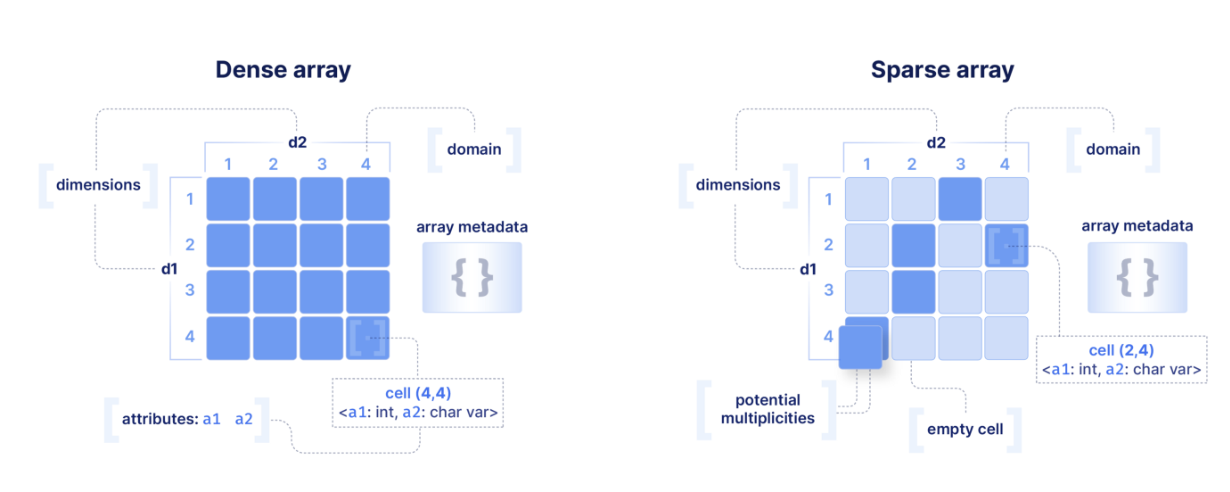
 

The dimensions of the array are features of the data that can be sliced very efficiently in TileDB (similar to an index on a dataframe)

The attribute is what kind of values are stored in the cells of the multidimensional array.


**Dense arrays** need to have a value for the attribute stored in each cell, even if its empty. 

**Sparse arrays** can have empty cells and will never be instantiated by TileDB

The decision of what dimensions, attribute types, and layout of the array is determined by the array schema. 




## Population Genomics


Whole genome and exome sequencing can characterize full frequency spectrum of human genetic variation. 

The Variant Call Format ([VCF](https://samtools.github.io/hts-specs/VCFv4.2.pdf)) is bioinformatics format to store sequence variants. 

(A little bit personal trivia - I was on the conference call in graduate school when the format was first proposed. My advisor wanted to call it Variant Call Report (VCR). Richard Durbin proposed VCF, and the rest is history)

There are a number of problems with the format, but one major one is this (taken from [Heng Li blog post](https://lh3.github.io/2015/02/23/the-problems-with-the-vcf-model) from 2015:

>Dense representation
VCF encodes a matrix of genotypes (site-by-sample) with a dense representation whereby it explicitly gives the genotype of every cell. For many samples, this matrix is sparse in the sense that the vast majority of cells are “0/0” (if the VCF is produced by multi-sample calling, including gVCF merging) or “./.” (if produced by merging). **The more samples, the more sites, the more sparse the matrix, and the more space and computation VCF costs. VCF is not scalable**

## VCFs and N+1

Suppose you had a large cohort of samples in which the variant calls were combined into a single multi-sample VCF. But then you sequence your next batch of samples and you want to combine this new set with your previously existing VCF. 

Since each human genome harbors hundreds of private variants, you have need to inject the genotype of the new variant across the entire dataset.

First, this is tedious and does not scale well. As scientists, we want to focus on science and not working around the shortcomings of a bioinformatics file format.

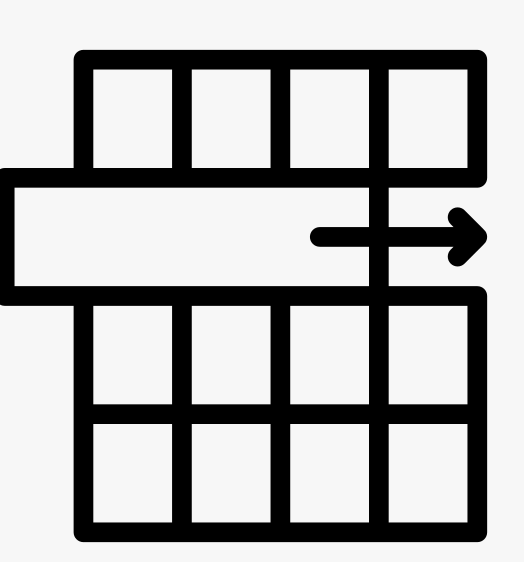





## TileDB-VCF

[TileDB-VCF](https://github.com/TileDB-Inc/TileDB-VCF) is an open-source library built on top of [TileDB Embedded](https://github.com/TileDB-Inc/TileDB) that allows efficient querying and ingesting of variant callsets. 


### Data model

#### Schema

| Parameter | Value |
|----------|----------|
| Array type    | Sparse   |
| Rank    | 3D   |
| Cell order    | Row major   |
| Tile order   | Row major   |

#### Dimensions

| Dimension | Datatype | VCF field |
|----------|----------|----------|
| contig    | ASCII string   | CHROM column   |
| start_pos    | uint32_t   | POS column plus TileDB anchors   |
| sample    | ASCII string  | Sample column   |


#### Attributes

| Attribute | Datatype | Description |
|----------|----------|----------|
| end_pos    | uint32_t  | calculated end of variant   |
| qual    | float  | VCF QUAL  column   |
| id    | varchar  | VCF ID column   |
| filter_ids | varchar | vector of FILTER values from VCF | 
| real_start_pos | uint32_t | VCF POS column (no TileDB anchors)
|info|  | var uint8_t | VCF INFO fields not stored as explicit attributes|
|fmt | var uint8_t | VCF FMT not stored as specific attributes |
|info_* | var uint8_t | One or more attributes storing specific VCF INFO fields, e.g. info_DP, info_MQ, etc. |
|fmt_* | var uint8_t | One or more attributes storing specific VCF FORMAT fields, e.g. fmt_GT, fmt_MIN_DP, etc. | 
| info_TILEDB_IAF | var float | computed allele frequency | 

#### Metadata

anchor gap value: The amount TileDB's query is expanded to the left of the query start. This fetches variants that overlap the query interval, but don't 
necessarily start within it.

extra attributes - INFO and FMT fields not stored as array attributes

version - schema version

### VCF Headers array

This contains the original text of the ingest VCF header so we can originall recover the VCF for any sample


## Advantages of TileDB-VCF

The array schema has modeled the variant data in the VCF as a sparse array with 3 dimensions contig x start pos x sample

We can efficiently query the data and most importantly, as the size of the cohort grows, we can easily add on to the existing TileDB array


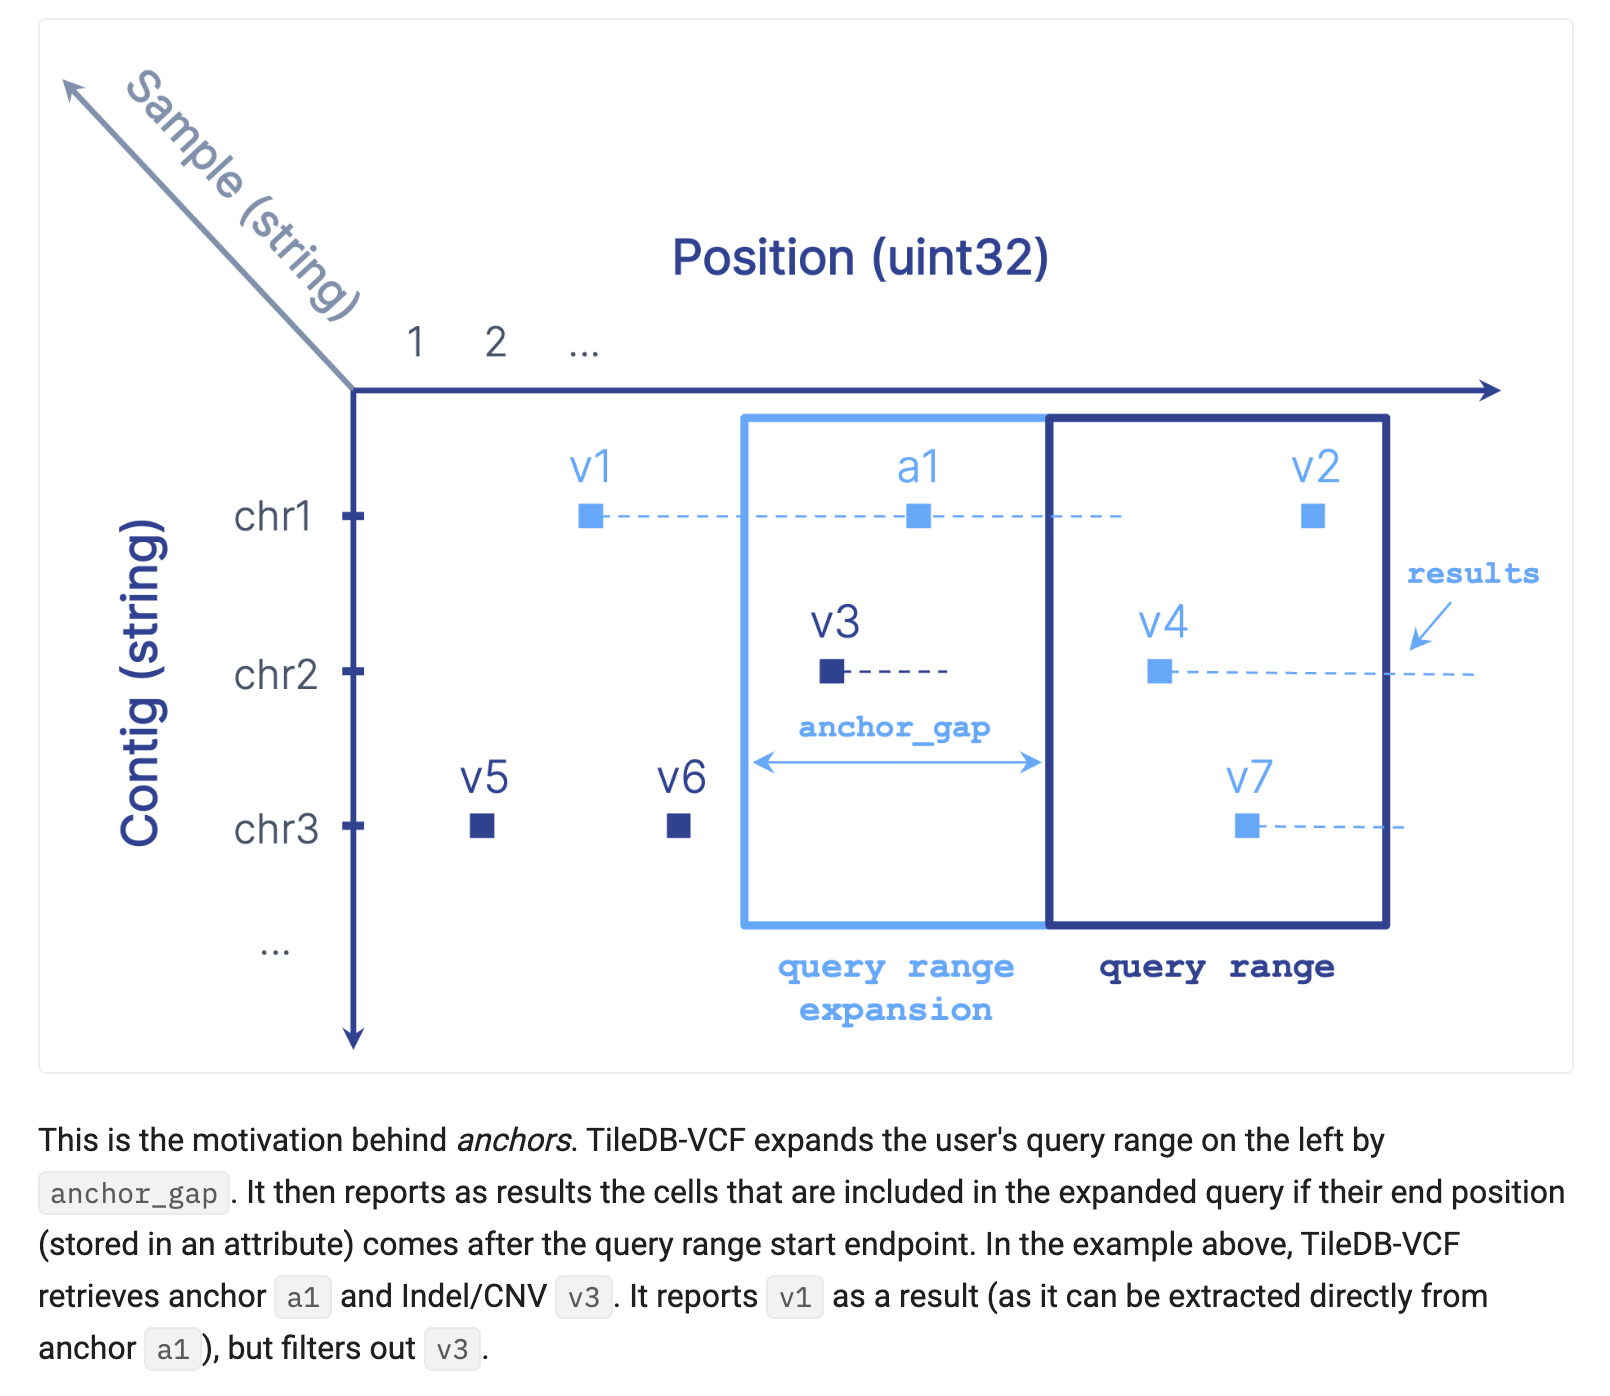



## N+1 problem

As you add additional data, the existing tiles ( the atomic unit of I/O for an array) are not affected. TileDB writes new data to tiles covering the relevant regions.

## Use case: compute polygenic risk score for trait(s) of interest across a cohort of sequenced samples


An early stage start up client is generating 200 whole genome sequencing (WGS) samples from [PacBio Revio instrument](https://www.pacb.com/revio/). The [Nextflow](https://seqera.io/) secondary analysis pipeline runs on AWS Batch. Variant calls are generated by DeepVariant and single sample VCF files are pushed to S3.

We want to process the variants in the VCF from the secondary analysis pipeline for polygenic risk scores.







## The non-TileDB way

Option 1: Submit parallel jobs or AWS batch jobs to query single sample VCFs with bcftools. Post process results to ingest into a Pandas dataframe.
Each time you access a file on S3, you incur a cost. 

Option 2: Generate a multi-sample VCF as batches of data come in. Then use bcftools to query the data and post process results into a pandas dataframe. 

Both options are less than ideal, and involve writing some tedious code.



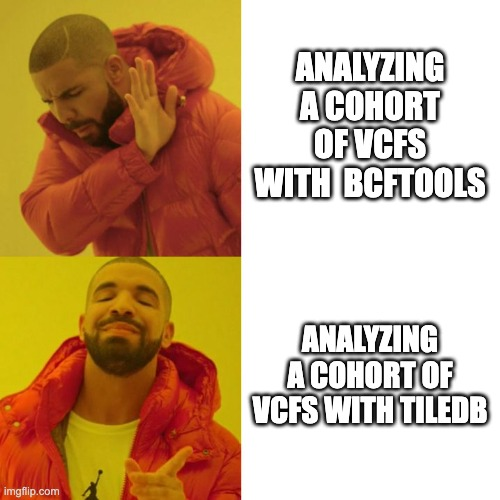





## The TileDB way

Let's use TileDB-VCF to see how easy and fast it is to ingest data into an array and query it for our analysis. 

## Let's first load the neccessary packages

These packages are already installed on TileDB cloud. Follow the steps [here](https://tiledb.com/blog/tiledb-101-population-genomics) install  on localhost 

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import tiledb
import tiledb.cloud
import tiledbvcf
import numpy as np

print(
    f"tiledb v{tiledb.version.version}\n"
    f"numpy v{np.__version__}\n"
    f"tiledb-vcf v{tiledbvcf.version}\n"
    f"tiledb-cloud v{tiledb.cloud.version.version}\n"
)

tiledb v0.32.0
numpy v1.25.0
tiledb-vcf v0.35.0
tiledb-cloud v0.12.29



## Set up configuration to access AWS

The input VCFs are pushed to S3 with Nextflow running on AWS Batch. Let's setup TileDB to be able to access the appropriate S3 bucket(s) with access/secret access keys

In [2]:
cfg = tiledb.Config()
with open(os.getenv('HOME') + '/env.bash') as A:
    for line in A.readlines():
        line = line.rstrip()
        if line == "":
            continue
        k, v = line.split('=')
        print(k)
        if k == 'TILEDB_VFS_S3_AWS_ACCESS_KEY_ID':
            cfg['vfs.s3.aws_access_key_id'] = v
            os.putenv('AWS_ACCESS_KEY_ID', v)
        if k == 'TILEDB_VFS_S3_SECRET_ACCESS_KEY':
            cfg['vfs.s3.aws_secret_access_key'] = v
            os.putenv('AWS_SECRET_ACCESS_KEY', v)
        if k == 'TILEDB_VFS_S3_REGION':
            cfg['vfs.s3.region'] = v
            os.putenv('AWS_DEFAULT_REGION', v)
cfg["py.init_buffer_bytes"] = 4 * 1024**3
ctx = tiledb.Ctx(cfg)
vfs = tiledb.VFS(cfg)



TILEDB_VFS_S3_AWS_ACCESS_KEY_ID
TILEDB_VFS_S3_SECRET_ACCESS_KEY
TILEDB_VFS_S3_REGION


Sanity check to see if we can access the bucket we will be using

In [3]:
! aws s3 ls s3://indapa-tiledb-interview/

                           PRE JupyterNotebooks/
                           PRE PGS/
                           PRE VCFs/


## S3 bucket to write our TileDB array to 

Below is the bucket we want write our VCF array to. 


Note, if we re-run the notebook, we cannot write to the same bucket because it already exists. We do a sanity check and delete if it exists. 



In [4]:
vcf_array_bucket_name="s3://indapa-tiledb-interview/VCFs/trio_arrays/"

In [49]:
# Check if the bucket exists, and if it does, remove it
if vfs.is_empty_bucket(vcf_array_bucket_name):
    print(f"The bucket {vcf_array_bucket_name} exists. Proceeding with deletion.")
    vfs.remove_bucket(bucket_name)
    print(f"The bucket {vcf_array_bucket_name} has been deleted.")
else:
    print(f"The bucket {vcf_array_bucket_name} does not exist.")

The bucket s3://indapa-tiledb-interview/VCFs/trio_arrays/ does not exist.


Next, list the URI on s3 for our VCF we want to ingest. We start with a single sample to begin.

In [5]:
vcf_bucket = "s3://indapa-tiledb-interview/VCFs/"


In [51]:
samples = ['HG002.m84011_220902_175841_s1.GRCh38.deepvariant.phased.vcf.gz']

In [52]:
sample_uris = [f"{vcf_bucket}/{s}" for s in samples]
sample_uris

['s3://indapa-tiledb-interview/VCFs//HG002.m84011_220902_175841_s1.GRCh38.deepvariant.phased.vcf.gz']

Instantiate a TileDB-VCF Dataset object in write mode. This sets up the process to write our VCF file to TileDB array. 

Initially create an empty dataset 

In [53]:
ds = tiledbvcf.Dataset(uri=vcf_array_bucket_name, mode="w", tiledb_config={"vfs.s3.region": "us-east-1"})

ds.create_dataset(enable_allele_count=True, enable_variant_stats=True)



Next, ingest the HG002 VCF from our secondary analysis pipeline result. This will take few minutes. 

In [54]:
%%time
ds.ingest_samples(sample_uris = sample_uris)

CPU times: user 2min 12s, sys: 20.6 s, total: 2min 33s
Wall time: 2min 19s


Let's take a look at the S3 URI:

In [8]:
! aws s3 ls s3://indapa-tiledb-interview/VCFs/trio_arrays 

                           PRE trio_arrays/


Woo hoo! We ingested our first WGS VCF callset into TileDB!

Let's the VCF array in read mode and see what samples are present. As expected, it's only a single sample, HG002

In [9]:

ds = tiledbvcf.Dataset(vcf_array_bucket_name, mode = "r")
ds.samples()

['HG002']

Let's take a look at the attributes:

In [61]:
ds.attributes()

['alleles',
 'contig',
 'filters',
 'fmt',
 'fmt_AD',
 'fmt_DP',
 'fmt_GQ',
 'fmt_GT',
 'fmt_MED_DP',
 'fmt_MIN_DP',
 'fmt_PL',
 'fmt_PS',
 'fmt_VAF',
 'id',
 'info',
 'info_END',
 'pos_end',
 'pos_start',
 'qual',
 'query_bed_end',
 'query_bed_line',
 'query_bed_start',
 'sample_name']

Let's take a look a a slice of data from the underlying array with the read function. The data is returned as a Pandas dataframe.

The sample, start position, and contig (chrom) are indexed dimensions in the array, so this should be pretty fast. 

In [63]:
%%time
df = ds.read(
    regions = ["chr6:151656672-152129618"], #ESR1 gene coordinates
    samples = ["HG002"],
    attrs = ["sample_name", "contig", "pos_start", "pos_end", 'filters', "fmt_GT"],
)
df.head()

CPU times: user 439 ms, sys: 244 ms, total: 684 ms
Wall time: 499 ms


,sample_name,contig,pos_start,pos_end,filters,fmt_GT
0,HG002,chr6,151657304,151657304,[PASS],"[0, 1]"
1,HG002,chr6,151658022,151658022,[PASS],"[0, 1]"
2,HG002,chr6,151658113,151658113,[PASS],"[0, 1]"
3,HG002,chr6,151658702,151658702,[PASS],"[0, 1]"
4,HG002,chr6,151659557,151659557,[PASS],"[0, 1]"


### Let's add the next sample to our VCF array

Next, let's add our next sample that just finished the secondary analysis pipeline and was pushed to S3. 

In [13]:

hg003_vcf_fname = "HG003.m84010_220919_235306_s2.GRCh38.deepvariant.phased.vcf.gz"

new_samples_uris = [f"{vcf_bucket}/{hg003_vcf_fname}"]

new_samples_uris


['s3://indapa-tiledb-interview/VCFs//HG003.m84010_220919_235306_s2.GRCh38.deepvariant.phased.vcf.gz']

In [14]:
# put the dataset object back in write mode

ds= tiledbvcf.Dataset(vcf_array_bucket_name, mode='w')

In [15]:
%%time

#ingest the new VCF into the existing array
ds.ingest_samples(sample_uris = new_samples_uris)


CPU times: user 2min 17s, sys: 20.3 s, total: 2min 38s
Wall time: 2min 21s


In [16]:
#put the dataset back in read mode

ds= tiledbvcf.Dataset(vcf_array_bucket_name, mode='r')

ds.samples()

['HG002', 'HG003']

## Polygenic risk scores (PRS)

PRS is an estimates an individual's risk of developing a trait or disease. It's determined by the number of copies of a risk allele person has, weighted by it's effect size (taken from GWAS results)

The [PGS catalog](https://www.pgscatalog.org/) is an open science source of PRS data. 

For this example, we downloaded PRS data for the trait of endometeriosis. trait_array_bucket = "s3://indapa-tiledb-interview/PGS/pgs_trait_array"
pgs_data_uri = "s3://indapa-tiledb-interview/PGS/PGS001866_hg38_updated.csv"
tiledb.from_csv(trait_array_bucket, 
                pgs_data_uri, ctx=ctx,
                sparse=True, index_col=['trait'])



In [19]:
trait_array_bucket = "s3://indapa-tiledb-interview/PGS/pgs_trait_array"
pgs_data_uri = "s3://indapa-tiledb-interview/PGS/PGS001866_hg38_updated.csv"
tiledb.from_csv(trait_array_bucket, 
                pgs_data_uri, ctx=ctx,
                sparse=True, index_col=['trait'])

In [20]:
! aws s3 ls {trait_array_bucket} 

                           PRE pgs_trait_array/


Open array for reading and take a look at the schema.

In [21]:
A = tiledb.open(trait_array_bucket, mode='r')
A.schema

ArraySchema(
  domain=Domain(*[
    Dim(name='trait', domain=('', ''), tile=None, dtype='|S0', var=True, filters=FilterList([ZstdFilter(level=-1), ])),
  ]),
  attrs=[
    Attr(name='rsID', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='chr_name', dtype='int64', var=False, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='chr_position', dtype='int64', var=False, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='effect_allele', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='other_allele', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='effect_weight', dtype='float64', var=False, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='hm_source', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='hm_rsID', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='hm_chr', dtype='int64', var=False, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='hm_pos', dtype='int64', var=False, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='hm_inferOtherAllele', dtype='float64', var=False, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='pgs_id', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='EFO', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
    Attr(name='weight_type', dtype='<U0', var=True, nullable=False, enum_label=None, filters=FilterList([ZstdFilter(level=-1), ])),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=True,
  allows_duplicates=True,
)

In [22]:
%%time
df = A.df['Endometriosis']

df.head()

CPU times: user 474 ms, sys: 98.1 ms, total: 572 ms
Wall time: 385 ms


,rsID,chr_name,chr_position,effect_allele,other_allele,effect_weight,hm_source,hm_rsID,hm_chr,hm_pos,hm_inferOtherAllele,pgs_id,EFO,weight_type
trait,,,,,,,,,,,,,,
Endometriosis,rs12532920,7,114203949,G,A,0.001176,ENSEMBL,rs12532920,7,114563894,NaN,PGS001866,EFO_0001065,beta
Endometriosis,rs10230087,7,114254407,A,G,-0.001188,ENSEMBL,rs10230087,7,114614352,NaN,PGS001866,EFO_0001065,beta
Endometriosis,rs4949162,1,5100883,G,A,0.000682,ENSEMBL,rs4949162,1,5040823,NaN,PGS001866,EFO_0001065,beta
Endometriosis,rs731770,7,128366485,A,G,-0.003542,ENSEMBL,rs731770,7,128726431,NaN,PGS001866,EFO_0001065,beta
Endometriosis,rs16826658,1,22485871,G,T,0.001536,ENSEMBL,rs16826658,1,22159378,NaN,PGS001866,EFO_0001065,beta


Slice the PGS trait array for SNPs that are associated with the trait endometriosis

## Compute the Polygenic Risk Score for Endometeriosis

The polygenic risk score is the measured genetic risk for a trait. It is calculated by summing the risk alleles of a set of variants, weighted by their effect sizes. The [PGS Catalog](https://www.pgscatalog.org/) is an open science database of published polygenic risk scores.

Let's use the VCF array and the PGS array containing effect sizes and risk alleles to compute the polygenic risk of published PGSs for endometriosis. 

Let's first make a helper function to return a region list 


In [23]:
import pandas as pd
def get_regions(df: pd.DataFrame) -> list:

    """
    Given a dataframe with columns 'hm_chr' and 'hm_pos', return a list of regions in the format 'chr1:1000-1000'   
    
    """
    assert 'hm_chr' in df.columns, 'hm_chr column not found'
    assert 'hm_pos' in df.columns, 'hm_pos column not found'

    return ('chr'+df['hm_chr'].astype(str) + ":" + df['hm_pos'].astype(str) + "-" + df['hm_pos'].astype(str)).tolist()

In [24]:
# get the region list of the SNPs associated with endometeriosis

region_list= get_regions(df)

print (f"total number of regions is {len(region_list)}")

total number of regions is 399


Next, we are going to pass that region list to the VCF array we created earlier

In [ ]:
%%time
res=ds.read(
    
    regions = region_list,
    attrs=['sample_name', 'contig', 'pos_start','pos_end', 'alleles', 'filters', 'fmt_GT'],
   
)
res.shape


In [130]:
# getting duplicates most likely due to some of the SNPs being in the expanded query range with anchor gap
res= res.drop_duplicates(['contig', 'pos_start', 'pos_end'])
res.shape

(240, 7)

## Join the VCF dataframe with the PGS trait dataframe

Joining the two will enable us to have what we need to calculate the PRS for our samples

In [ ]:
df['hm_chr'] = 'chr' + df['hm_chr'].astype(str) # prepend the chr prefix
df= df.reset_index() # get the trait as a column

merged_df = pd.merge(df, res, left_on=['hm_chr', 'hm_pos'], right_on=['contig', 'pos_start'])

In [126]:
merged_df

,index,trait,rsID,chr_name,chr_position,effect_allele,other_allele,effect_weight,hm_source,hm_rsID,...,pgs_id,EFO,weight_type,sample_name,contig,pos_start,pos_end,alleles,filters,fmt_GT
0,0,Endometriosis,rs12532920,7,114203949,G,A,0.001176,ENSEMBL,rs12532920,...,PGS001866,EFO_0001065,beta,HG002,chr7,114563894,114563894,"[A, G]",[PASS],"[1, 0]"
1,1,Endometriosis,rs10230087,7,114254407,A,G,-0.001188,ENSEMBL,rs10230087,...,PGS001866,EFO_0001065,beta,HG002,chr7,114614352,114614352,"[G, A]",[PASS],"[0, 1]"
2,4,Endometriosis,rs16826658,1,22485871,G,T,0.001536,ENSEMBL,rs16826658,...,PGS001866,EFO_0001065,beta,HG002,chr1,22159378,22159378,"[T, G]",[PASS],"[1, 0]"
3,6,Endometriosis,rs181585,10,119327897,C,T,0.006205,ENSEMBL,rs181585,...,PGS001866,EFO_0001065,beta,HG002,chr10,117568386,117568386,"[T, C]",[PASS],"[1, 1]"
4,7,Endometriosis,rs353620,11,35174136,G,A,0.000249,ENSEMBL,rs353620,...,PGS001866,EFO_0001065,beta,HG003,chr11,35152589,35152589,"[A, G]",[PASS],"[0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,393,Endometriosis,rs2547952,5,98051255,C,T,-0.001315,ENSEMBL,rs2547952,...,PGS001866,EFO_0001065,beta,HG002,chr5,98715551,98715551,"[T, C]",[PASS],"[1, 1]"
236,395,Endometriosis,rs318105,5,92945156,C,T,-0.003965,ENSEMBL,rs318105,...,PGS001866,EFO_0001065,beta,HG002,chr5,93609450,93609450,"[T, C]",[PASS],"[1, 1]"
237,396,Endometriosis,rs269705,5,92731616,G,T,-0.000591,ENSEMBL,rs269705,...,PGS001866,EFO_0001065,beta,HG002,chr5,93395910,93395910,"[T, G]",[PASS],"[0, 1]"
238,397,Endometriosis,rs11135387,5,92695225,C,T,-0.000784,ENSEMBL,rs11135387,...,PGS001866,EFO_0001065,beta,HG002,chr5,93359519,93359519,"[T, C]",[PASS],"[0, 1]"


Next, we are going to add a column representing the sum of the total number of risk (non-reference) alleles for each SNP.

Using that, next we calculate the contribution of the sample genotype to the PRS.


In [ ]:
merged_df['fmt_GT_sum'] = merged_df['fmt_GT'].apply(lambda x: np.sum(x) if x is not None else 0)
#replace NaN with 0 for column fmt_GT_sum

merged_df['fmt_GT_sum'] = merged_df['fmt_GT_sum'].fillna(0)

merged_df['prs_contribution'] = merged_df['fmt_GT_sum'] * merged_df['effect_weight']

merged_df

Calculate the PRS for each sample and each PGS id

In [128]:
prs_by_sample_pgs = merged_df.groupby(['sample_name', 'trait','pgs_id'])['prs_contribution'].sum().reset_index()

In [129]:
prs_by_sample_pgs

,sample_name,trait,pgs_id,prs_contribution
0,HG002,Endometriosis,PGS001866,0.146032
1,HG003,Endometriosis,PGS001866,0.023202


## Summary

We did the following with TileDB to calculate polygenic risk score on our WGS VCFs:
    
   - Created a VCF array to store our VCF callsets 
    
   - Ingested 2 VCF files with TileDB-VCF
    
   - Created a sparse 1D array to store PGS weights of SNPs associated with endometeriosis. 
    
   - Joined VCF calls with PGS data to efficiently calculate PRS scores for our samples
   
   As we grow our cohort , we can easily add to our VCF array, efficiently solving the N+1 problem. 
   
   https://docs.tiledb.com/main/background/use-cases/genomics/population-genomics
   
   
   

## Next steps


Try out TileDB yourself! Get started on [TileDB](https://tiledb.com/) today!

## Streamlit app

Let's make a simple [Streamlit](https://streamlit.io/) web application with TileDB under the hood .


We basically use the same code from the notebook, but make an accessible user interface for project stakeholders across the organization to explore the data.


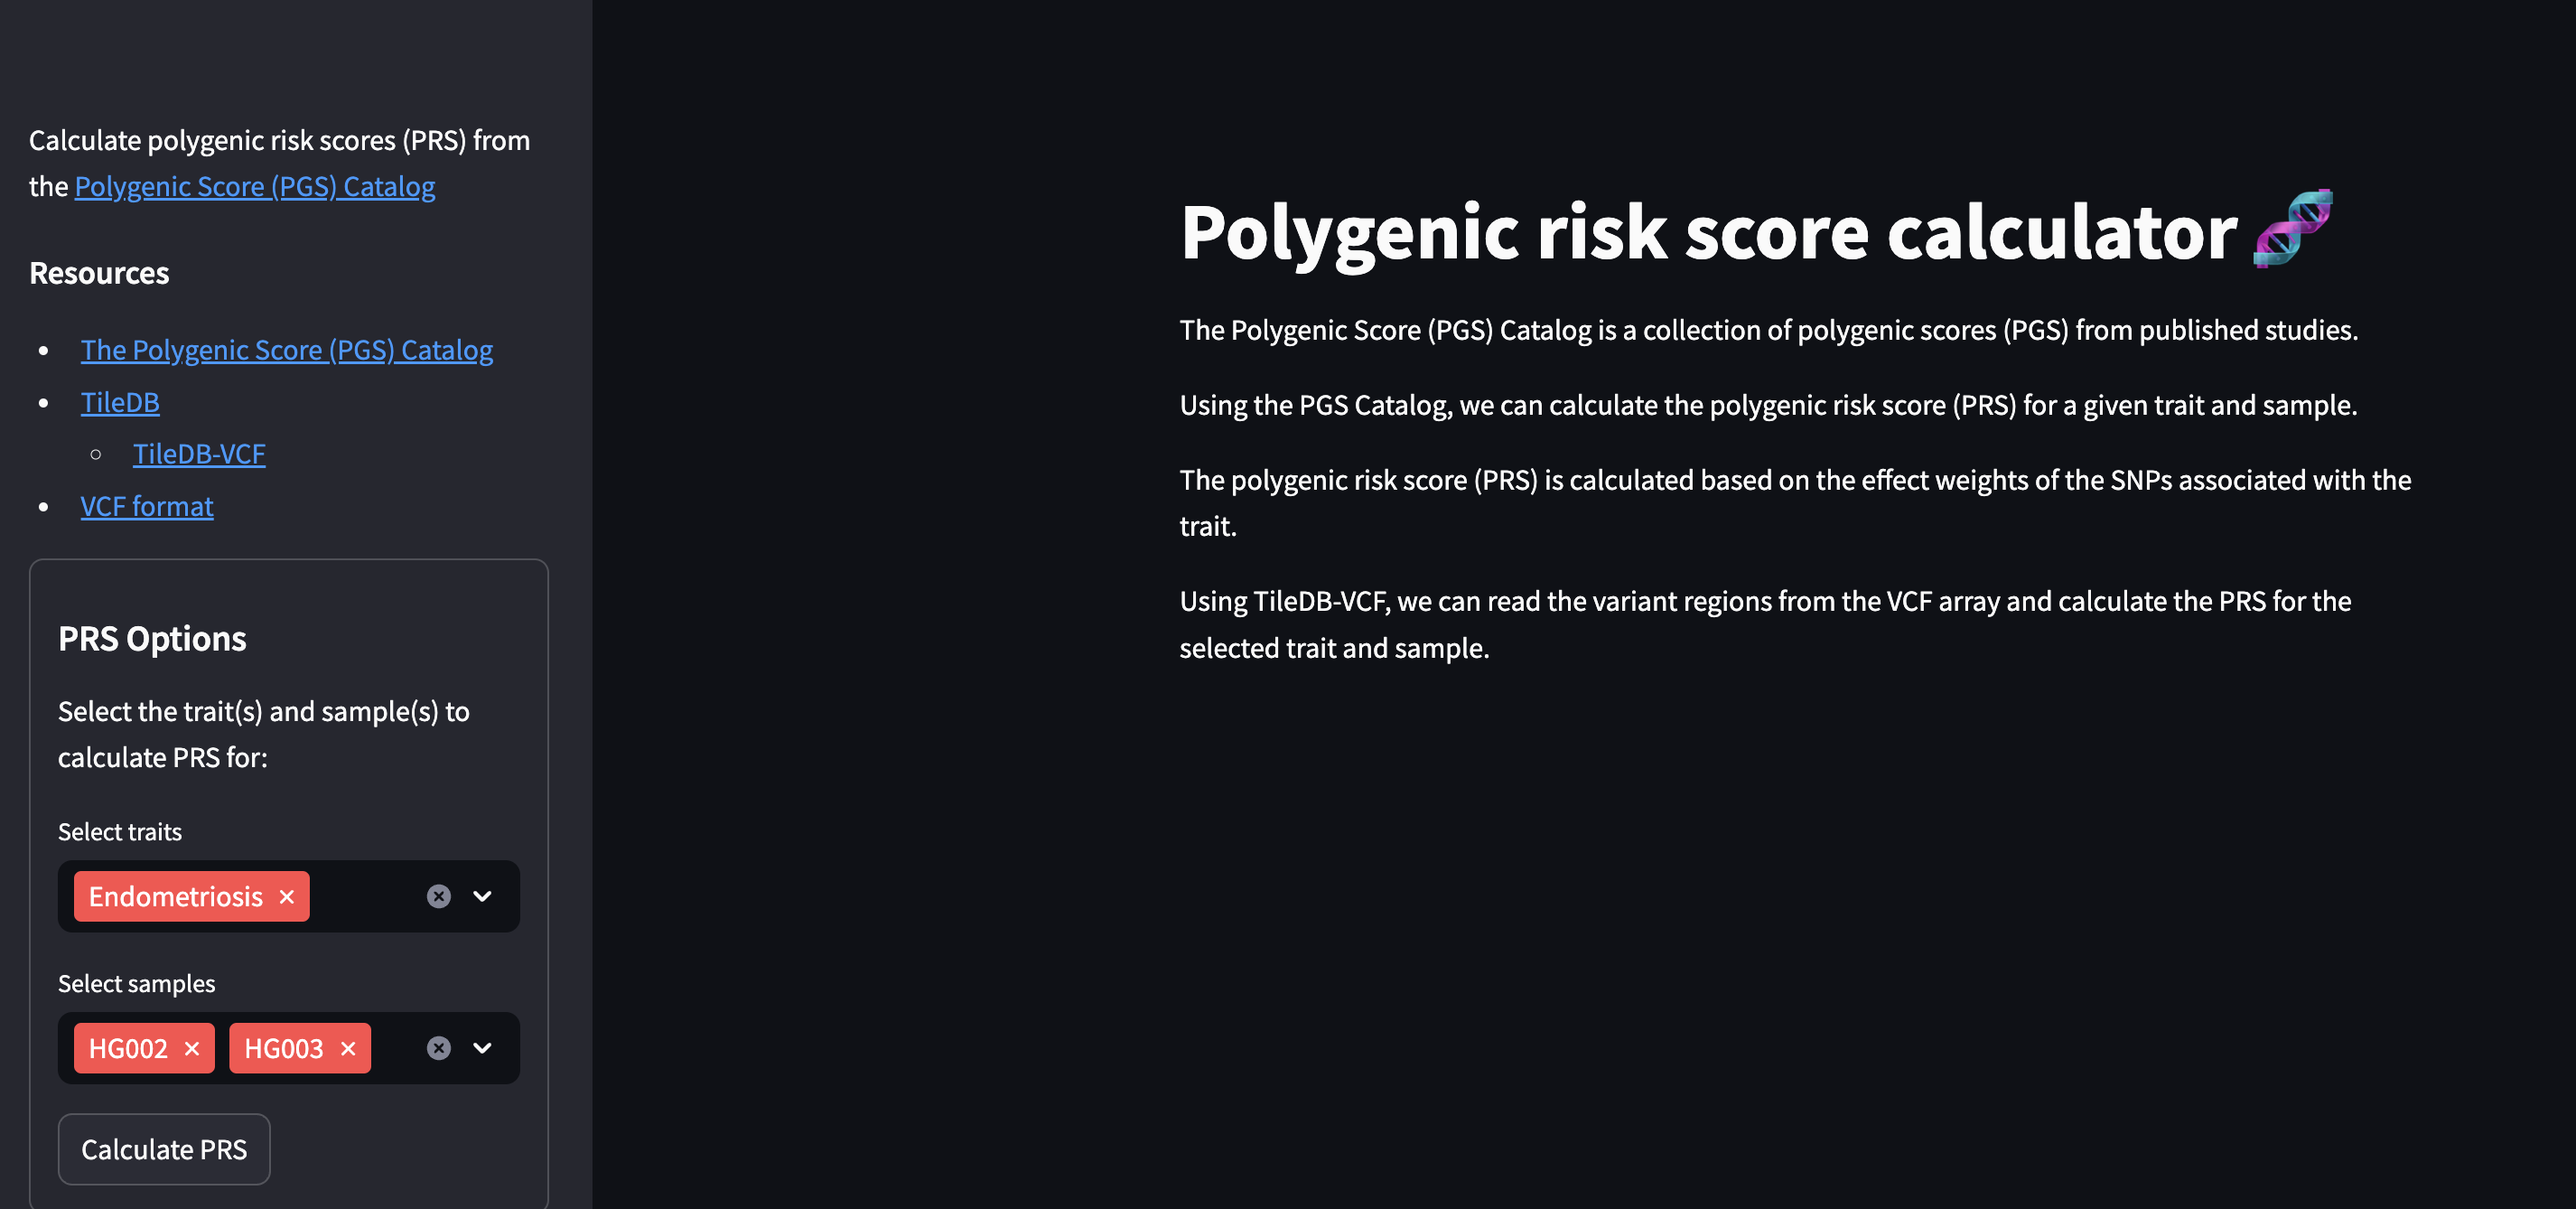


